## Gradient Descent and Variants on MNIST Digit Recognition



### Objectives

We consider the familiar problem of digit recognition. We have 2 main objectives:

1.  Observe the training time (time required for convergence) among the different versions of __gradient descent__ algorithms,
2.  Build a model to predict the digits, in pair-wise classification task.

The different versions of _gradient descent_ algorithms we will consider are:

*  (Standard) Gradient Descent (GD)
*  Stochastic Gradient Descent (SGD)
*  Minibatch Gradient Descent (MBGD)
*  MBGD with Momentum
*  MBGD with Nesterov Acceleration

###### Data

The data is the classic [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The dataset is a collection of images of single digits $\{0,1,2,3,4,5,6,7,8,9\}$. The training set has $60,000$ examples and the test set has $10,000$ examples. Further information can be found on the [website](http://yann.lecun.com/exdb/mnist/).

##### Contents

1. [The Problem](#Problem) <br>
    1.1. [Derivation of the Problem](#Derivation) <br>
    1.2. [Gradient Descent and Variants](#GD_Variants) <br>
2. [Code Implementation](#Code) <br>
    2.1. [Packages and Data Loading](#Loading) <br>
    2.2. [Helper Functions](#Helper_Functions) <br>
    2.3. [Main Functions, Gradient Descent](#Main_Functions) <br>
    2.4. [Model Building](#Model_Building) <br>
    2.5. [Model Evaluation](#Model_Evaluation) <br>


<br/>

### 1.  <a id = 'Problem'> The Problem </a>

#### 1.1.  <a id = 'Derivation'> Derivation of the Problem </a>

We will model this as a binary classification problem: we will built model to predict between every 2 digits. Put formally, suppose we have some data points $\{x_i, y_i\}_{i=1}^N \in \mathbb{R}^d \times \mathbb{R}$, where $x_i$ is the feature vector (in this case a $784$-dimension vector of pixel values), $y_i \in \{-1,1\}$ is the class label, and $N$ is the number of training points.

Given $(x_i, y_i)$, we will model $y_i = sign(w^T x_i)$, where $w \in \mathbb{R}^d$ is the parameter we want to find. The associated cost function $F$ is thus

$$
    F(w) 
    \ = \ \frac{1}{N} \sum_{i=1}^N f_i(w)
    \ = \ \frac{1}{N} \sum_{i=1}^N \log\left( 1 + e^{-w^T x_i y_i} \right)
$$

where $f_i = \log\left( 1 + e^{-w^T x_i y_i} \right)$ be the loss associated with the $i^{th}$ data point $(x_i, y_i)$.

Given $F$, the gradient $\nabla_w F$ with respect to $w$ is thus

$$
    \nabla F
        \ = \ \frac{1}{N} \sum_{i=1}^N \nabla f_i
        \ = \ \left( \frac{1}{N} \sum_{i=1}^N \frac{- e^{- w^T x_i y_i} }{1 + e^{- w^T x_i y_i}} \left( x_i y_i \right) \right)
        \ = \ \left( \frac{1}{N} \sum_{i=1}^N \frac{ 1 }{1 + e^{w^T x_i y_i}} \left( - x_i y_i \right) \right)
$$

<br/>

#### 1.2.  <a id = 'GD_Variants'> Gradient Descent and Variants </a>

We recall the update rule in the __gradient descent__ algorithm: given the current weight $w^t$, we update it as

$$
    w^{(t+1)}
    \ = \ w^t - \alpha_t \sum_{i=1}^k \nabla f_i(w^t)
$$

where if $k = N$, we have the base *gradient descent*, $k = 1$ *stochastic gradient descent*, and $1 < k < N$ (common choices include $k = 16$ or $32$) *minibatch gradient descent*. Without loss of generality, suppose we start with minibatch gradient descent, we can boost the convergence with a *momentum*. For example:

*  GD with *momentum*, 
$$w^{(t+1)} \ = \ w^t - \left( \alpha_t \sum_{i=1}^k \nabla f_i(w^t) \right) + \beta_t\left( x^t - x^{(t-1)} \right)$$
*  GD with Nesterov acceleration, 
$$w^{(t+1)} \ = \ w^t - \left( \alpha \sum_{i=1}^k \nabla f_i \left(w^t + \beta_t(w^t - w^{(t-1)}) \right) \right) + \beta_t \left( w^t + \beta_t(w^t - w^{(t-1)}) \right)$$


<br/>

### 2.  <a id = 'Code'> Code Implementation </a>

#### 2.1.  <a id = 'Loading'> Packages and Data Loading </a>

We first load the necessary packages.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import time
from IPython.display import Image

We now load the datasets and rename `Label` column.

In [2]:
data_train = pd.read_csv('mnist_train.csv', header=None)
data_test = pd.read_csv('mnist_test.csv', header=None)
data_train.rename(columns={ data_train.columns[0]: "Label" }, inplace = True)
data_test.rename(columns={ data_test.columns[0]: "Label" }, inplace = True)

In [3]:
print('-----------------------------' + '\n' + 'Number of observations per digits' + '\n' + '-----------------------------')
print('\n' + '-----------------------------' + '\n' + 'Train set:')
print(np.array(np.unique(data_train['Label'], return_counts=True)))
print('\n' + '-----------------------------' + '\n' + 'Test set:')
print(np.array(np.unique(data_test['Label'], return_counts=True)))

-----------------------------
Number of observations per digits
-----------------------------

-----------------------------
Train set:
[[   0    1    2    3    4    5    6    7    8    9]
 [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]]

-----------------------------
Test set:
[[   0    1    2    3    4    5    6    7    8    9]
 [ 980 1135 1032 1010  982  892  958 1028  974 1009]]


<br/>

#### 2.2.  <a id = 'Helper_Functions'> Helper Functions </a>

We write some functions for later use:

*  `getData(df, digits, n)` to get `n` random observations from the data set `df` with desired digits `digits`
*  `loss_fn(df, w)` to compute the loss on the data set `df` given current weight `w`
*  `grad_F(df, w)` to compute the gradient given the training points `df` and current weight `w`
*  `getError(df, w)` to compute the *error rate* on the data set `df` given current weight `w`
*  `plot` to plot the training losses

`getData(df,digits,n)`

In [4]:
def getData( df, digits, n ):
    
    # Shuffle observations
    indices = np.arange(df.shape[0])
    np.random.shuffle(indices)
    df = df.iloc[indices]
    
    # Get observations based on wanted digits
    data = df[df['Label'].isin(digits)].groupby('Label').head(n)
    
    # Set the labels to {-1,1}
    data['Label'] = np.sign( data['Label'] - sum(digits)/len(digits) )
    
    return data

`loss_fn(df, w)`

In [5]:
def loss_fn(df, w):
    
    # Get appropriate data points & labels
    X = df.drop('Label', axis = 1) / 255
    Y = df['Label']
    
    term_e = np.dot(w, X.transpose()) * Y
    term_e = np.exp(- term_e)
    term_log = np.log( 1 + term_e )

    return term_log.mean()

`grad_F(df, w)`

In [6]:
def grad_F(df, w):
    
    # Get appropriate data points & labels
    X = df.drop('Label', axis = 1) / 255
    Y = df['Label']
    N = len(Y)
    
    # Compute gradient of sum
    term_e = np.exp( np.dot( X, w ) * Y )
    term_e = np.array( 1/(1+term_e) * Y )
    # Reshape vector to matrix
    term_e = np.repeat(term_e, d).reshape( N, d )
    grad_mat = term_e * X
    grad = np.sum( grad_mat, axis = 0 )
    
    # Total gradient
    return - grad / N

`getError(df,w)`

In [7]:
def getError(df,w):
    # Get appropriate data points & labels
    X = df.drop('Label', axis = 1) / 255
    Y = df['Label']
    # Prediction
    pred = np.sign(np.dot(X,w))
    # Error rate
    error = np.mean(pred != Y)
    return error

`plot(loss, plt_alpha, plt_color, plt_label)`

In [8]:
def plot(loss, plt_alpha, plt_color, plt_label):
    plt.plot(idx, loss, '-', color = plt_color, alpha = plt_alpha, 
         label = plt_label)

<br/>

#### 2.3.  <a id = 'Main_Functions'> Main Functions, Gradient Descent </a>

Here we write 2 functions to run the base *gradient descent* and GD with acceleration:

*  `Grad_Desc(df, w, k, alpha, T)` to run base *gradient descent*, where `k` is the number of training points used per iterate
*  `GD_Accelerated(df, w, k, alpha, beta, T, variant)` to run GD with accelertion, where `variant` is to specify either *momentum* or *Nesterov acceleration*

<br/>

`Grad_Desc(df, w, k, alpha, T)`:
*  `df, w`: training dataset and the initial $w^{(0)}$
*  `k`: which controls the between GD, Stochastic GD, and Minibatch GD: 
    *  `k = all`: GD
    *  `k = 1`: Stochastic GD
    *  `k = 16`: Minibatch GD, (or $k$ can be any number of data points to be used per iterate)
*  `alpha`: the step-size per iterate
*  `T`: the number of iterate (aka the stopping criteria)

In [9]:
def Grad_Desc( df, w, k, alpha, T ):
    
    loss_vector = [0]*T     # Initialize vector to track loss fn
    
    for t in range(0,T):
        loss_vector[t] = loss_fn( df, w )
        
        if k == 'all':
            data = df
        else:
            # Get sampled data points
            indices = np.random.choice( np.arange( df.shape[0] ), k, replace = False )
            data = df.iloc[indices]
        
        # Train model
        w = w - alpha * grad_F( data, w )
    
    return loss_vector, w

<br/>

`GD_Accelerated(df, w, k, alpha, beta, T, variant)`
*  `df, w`: training dataset and the initial $w^{(0)}$
*  `k`: the number of data points to be used per iterate
*  `alpha`: the step-size per iterate
*  `beta`: the momentum parameter
*  `T`: the number of iterate (aka the stopping criteria)
*  `variant`: to choose which variant: `momentum` or `Nesterov`

In [10]:
def GD_Accelerated( df, w, k, alpha, beta, T, variant ):
    
    loss_vector = [0]*T
    w_prv = w
    
    for t in range(0,T):
        loss_vector[t] = loss_fn( df, w )
        
        # Get sampled data points
        indices = np.random.choice( np.arange( df.shape[0] ), k, replace = False )
        data = df.iloc[indices]
        
        # Train model
        if variant == 'momentum':
            w_tmp = w - alpha * grad_F( data, w ) + beta * (w - w_prv)
        elif variant == 'Nesterov':
            w_mmt = w + beta * (w - w_prv)
            w_tmp = w_mmt - alpha * grad_F(data, w_mmt)
        else:
            print('Error: Acceleration not found')
            break
        
        w_prv = w
        w     = w_tmp
        
    return loss_vector, w

<br/>

#### 2.4.  <a id = 'Model_Building'> Model Building </a>

We are now ready to build the model. For demonstration, we will train the model to predict $1$ versus $7$.

We first get the necessary train and test sets.

In [11]:
digits = [1,7]
train = getData(data_train, digits, 2000)
test = getData(data_test, digits, 500)

# Dimension of variables
d = train.shape[1] - 1

We now run the algorithms to train the model.

In [12]:
T = 1000
alpha, beta = .0005, .8

# Vanilla Gradient Descent ---------------------------------
# Gradient Descent
start_time = time.perf_counter()
w = np.zeros(d)
k = 'all'
loss_GD, w_GD = Grad_Desc( train, w, k, alpha, T )
time_GD = time.perf_counter() - start_time

# Stochastic Gradient Descent
start_time = time.perf_counter()
w = np.zeros(d)
k = 1
loss_SGD, w_SGD = Grad_Desc( train, w, k, alpha, T )
time_SGD = time.perf_counter() - start_time

# Minibatch Gradient Descent
start_time = time.perf_counter()
w = np.zeros(d)
k = 32
loss_MBGD, w_MBGD = Grad_Desc( train, w, k, alpha, T )
time_MBGD = time.perf_counter() - start_time


# Gradient Descent with Acceleration -----------------------
k = 32

# Minibatch Gradient Descent with Momentum
start_time = time.perf_counter()
w = np.zeros(d)
loss_MBGD_MMT, w_MBGD_MMT = GD_Accelerated( train, w, k, alpha, beta, T, 'momentum' )
time_MBGD_MMT = time.perf_counter() - start_time

# Minibatch Gradient Descent with Nesterov Acceleration
start_time = time.perf_counter()
w = np.zeros(d)
loss_MBGD_Nest, w_MBGD_Nest = GD_Accelerated( train, w, k, alpha, beta, T, 'Nesterov' )
time_MBGD_Nest = time.perf_counter() - start_time

Training is now complete, let us look at the losses over the training.

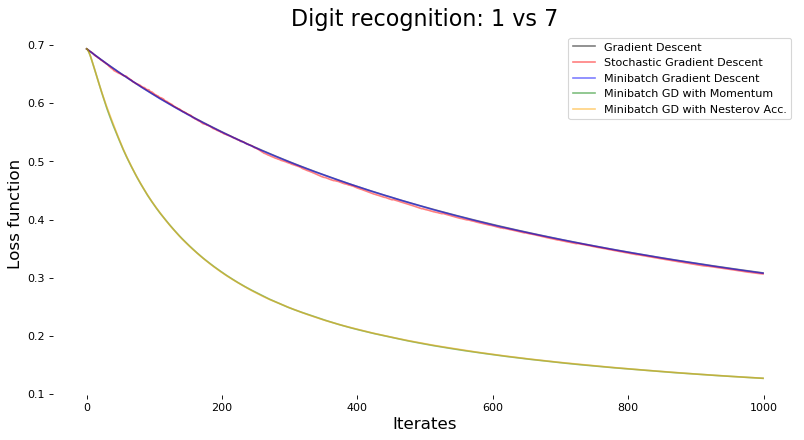

In [13]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.box(False)

idx = np.arange(0, T)
# Plot of loss functions
plot(loss_GD, .5, 'black', 'Gradient Descent')
plot(loss_SGD, .5, 'red', 'Stochastic Gradient Descent')
plot(loss_MBGD, .5, 'blue', 'Minibatch Gradient Descent')
plot(loss_MBGD_MMT, .5, 'green', 'Minibatch GD with Momentum')
plot(loss_MBGD_Nest, .5, 'orange', 'Minibatch GD with Nesterov Acc.')

plt.title('Digit recognition: 1 vs 7', fontsize = 20)
plt.xlabel('Iterates', fontsize = 15); plt.ylabel('Loss function', fontsize = 15)
plt.axis()
plt.legend()

plt.savefig('MNIST Digits - Algorithms convergence rates.png', bbox_inches='tight')

#### 2.5.  <a id = 'Model_Evaluation'> Model Evaluation </a>

Now that the training is completed, let us evaluate the model via the error rates on both the train and test sets.

In [14]:
w_trained = [w_GD, w_SGD, w_MBGD, w_MBGD_MMT, w_MBGD_Nest]

Err_Train = []
Err_Test = []
for w in w_trained:
    Err_Train.append(round(getError( train, w),3))
    Err_Test.append(round(getError( test, w),3))

In [15]:
algs = np.array(['Gradient Descent', 'Stochastic GD', 'Minibatch BGD', 'GD w/ Momentum', 'GD w/ Nesterov Acc'])
runtime = np.around( np.array([time_GD, time_SGD, time_MBGD, time_MBGD_MMT, time_MBGD_Nest]) / 60, 2)

df = pd.DataFrame(columns = algs)
df.loc['Error: Train set'] = Err_Train
df.loc['Error: Test set'] = Err_Test
df.loc['Run Time (min)'] = runtime

line = '----------------------------------------------------------'
print(line + '\n' + 'Algorithm Statistics:' + '\n' + line)
df

----------------------------------------------------------
Algorithm Statistics:
----------------------------------------------------------


,Gradient Descent,Stochastic GD,Minibatch BGD,GD w/ Momentum,GD w/ Nesterov Acc
Error: Train set,0.029,0.032,0.030,0.024,0.024
Error: Test set,0.036,0.037,0.037,0.034,0.034
Run Time (min),4.310,1.120,1.160,1.180,1.190


To conclude, we have some observations:

*  *Model accuracy*: with the exception of stochastic GD, all the other variants have very similar (and good) error rates,
*  *Runtime complexity*: we observe the big difference between training on the entire dataset (base GD) versus on a subset (minibatch GD).